# Converting the National Travel Survey into a Simple MATSim Format Population

This notebook demonstrates an example workflow for converting tabular diary data from UK NTS (household attributes, person attributes and trip data) into MATSim formatted xml population data for London households.

This includes:
- pre-processing of tabular inputs
- loading data into pam
- household sampling
- facility sampling
- preliminary investigation
- writing to xml

This example is highly simplified. Of particular note: the diary data used is spatially very aggregate (trip locations are aggregated to inner/outer London). This creates significant variance in the sampled trip lengths. Generally we would expect more precise spatial data to be used. Alternately the complexity of the facility sampling step can be improved to better account for known trip features such as mode and duration.

The diary data used is available from the UK Data Service (https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=5340) and is described here:http://doc.ukdataservice.ac.uk/doc/5340/mrdoc/pdf/5340_nts_user_guidance_1995-2016.pdf

In [1]:
import os

import geopandas as gp
import pandas as pd

from pam import read, write
from pam.plot.stats import plot_activity_times, plot_leg_times
from pam.samplers.spatial import RandomPointSampler

In [2]:
use_dummy_data = True

In [3]:
out_dir = "./outputs"  # outputs are writen here

# required inputs from the National Travel Survey
if use_dummy_data:
    households_csv = "./data/dummyNTS/householdeul2017.tab"
    individuals_csv = "./data/dummyNTS/individualeul2017.tab"
    trips_csv = "./data/dummyNTS/tripeul2017.tab"

else:
    households_csv = "~/Data/UKDA-5340-tab/tab/householdeul2017.tab"
    individuals_csv = "~/Data/UKDA-5340-tab/tab/individualeul2017.tab"
    trips_csv = "~/Data/UKDA-5340-tab/tab/tripeul2017.tab"

## Load data

### Load households data

1. Load household data into pandas DataFrame.
2. Create some mappings of participation and weighting by household for use later. These are described in http://doc.ukdataservice.ac.uk/doc/5340/mrdoc/pdf/5340_nts_user_guidance_1995-2016.pdf

In [4]:
hh_in = pd.read_csv(
    households_csv,
    sep="\t",
    usecols=[
        "HouseholdID",
        "SurveyYear",
        "PSUID",
        "W2",
        "OutCom_B02ID",
        "HHIncome2002_B02ID",
        "AddressType_B01ID",
        "Ten1_B02ID",
        "Landlord_B01ID",
        "ResLength_B01ID",
        "HHoldCountry_B01ID",
        "HHoldGOR_B02ID",
        "HHoldNumAdults",
        "HHoldNumChildren",
        "HHoldNumPeople",
        "HHoldStruct_B02ID",
        "NumLicHolders",
        "HHoldEmploy_B01ID",
        "NumVehicles",
        "NumBike",
        "NumCar",
        "NumMCycle",
        "NumVanLorry",
        "NumCarVan",
        "WalkBus_B01ID",
        "Getbus_B01ID",
        "WalkRail_B01ID",
        "WalkRailAlt_B01ID",
        "HRPWorkStat_B02ID",
        "HRPSEGWorkStat_B01ID",
        "HHoldOAClass2011_B03ID",
        "Settlement2011EW_B03ID",
        "Settlement2011EW_B04ID",
    ],
)

hh_in.HHIncome2002_B02ID = pd.to_numeric(hh_in.HHIncome2002_B02ID, errors="coerce")
hh_in.NumLicHolders = pd.to_numeric(hh_in.NumLicHolders, errors="coerce")
hh_in.NumVehicles = pd.to_numeric(hh_in.NumVehicles, errors="coerce")
hh_in.NumCar = pd.to_numeric(hh_in.NumCar, errors="coerce")
hh_in.NumMCycle = pd.to_numeric(hh_in.NumMCycle, errors="coerce")
hh_in.NumVanLorry = pd.to_numeric(hh_in.NumVanLorry, errors="coerce")
hh_in.NumCarVan = pd.to_numeric(hh_in.NumCarVan, errors="coerce")
hh_in.Settlement2011EW_B04ID = pd.to_numeric(hh_in.Settlement2011EW_B04ID, errors="coerce")

hh_in.head()

,HouseholdID,SurveyYear,PSUID,W2,OutCom_B02ID,HHIncome2002_B02ID,AddressType_B01ID,Ten1_B02ID,Landlord_B01ID,ResLength_B01ID,...,NumCarVan,WalkBus_B01ID,Getbus_B01ID,WalkRail_B01ID,WalkRailAlt_B01ID,HRPWorkStat_B02ID,HRPSEGWorkStat_B01ID,HHoldOAClass2011_B03ID,Settlement2011EW_B03ID,Settlement2011EW_B04ID
0,1,2002,1,1,1,2,3,1,-10,3,...,2,1,5,1,-9,1,3,-10,1,1
1,2,2002,1,1,1,1,3,1,-10,8,...,0,1,5,2,-9,3,5,-10,1,1
2,3,2002,1,1,1,3,3,1,-10,8,...,2,1,4,3,-9,1,3,-10,1,1


In [5]:
participation_mapping = dict(zip(hh_in.HouseholdID, hh_in.OutCom_B02ID))
weight_mapping = dict(zip(hh_in.HouseholdID, hh_in.W2))

### Load person data

Load person attributes data into pandas DataFrame.

In [6]:
persons_in = pd.read_csv(
    individuals_csv,
    sep="\t",
    usecols=[
        "SurveyYear",
        "IndividualID",
        "HouseholdID",
        "PSUID",
        "VehicleID",
        "PersNo",
        "Age_B01ID",
        "OfPenAge_B01ID",
        "Sex_B01ID",
        "EdAttn1_B01ID",
        "EdAttn2_B01ID",
        "EdAttn3_B01ID",
        "DrivLic_B02ID",
        "CarAccess_B01ID",
        "DrivDisable_B01ID",
        "WkPlace_B01ID",
        "ES2000_B01ID",
        "NSSec_B03ID",
        "SC_B01ID",
        "Stat_B01ID",
        "SVise_B01ID",
        "EcoStat_B02ID",
        "PossHom_B01ID",
    ],
)
persons_in.head()

,SurveyYear,IndividualID,HouseholdID,PSUID,VehicleID,PersNo,Age_B01ID,OfPenAge_B01ID,Sex_B01ID,EdAttn1_B01ID,...,CarAccess_B01ID,DrivDisable_B01ID,WkPlace_B01ID,ES2000_B01ID,NSSec_B03ID,SC_B01ID,Stat_B01ID,SVise_B01ID,EcoStat_B02ID,PossHom_B01ID
0,2002,1,1,1,1,1,13,2,2,-10,...,2,-9,1,7,2,3,1,2,2,2
1,2002,2,1,1,2,2,13,2,1,-10,...,2,-9,1,7,3,4,1,2,1,2
2,2002,3,1,1,,3,4,2,1,-10,...,4,-9,-9,-9,-9,-9,-9,-9,-9,-9
3,2002,4,1,1,,4,2,2,2,-10,...,4,-9,-9,-9,-9,-9,-9,-9,-9,-9
4,2002,5,2,1,,1,18,1,2,-10,...,6,2,-9,6,1,3,1,1,4,-9


### load trip data

1. Load trip data into pandas DataFrame format.
2. Apply some preliminary formatting
3. Replace headers so that we can use pam read method:


- pid - person ID
- hid - household ID
- seq - trip sequence number
- hzone - household zone
- ozone - trip origin zone
- dzone - trip destination zone
- purp - trip purpose
- mode - trip mode
- tst - trip start time (minutes)
- tet - trip end time (minutes)
- freq - weighting for representative population

In [7]:
travel_diaries_in = pd.read_csv(
    trips_csv,
    sep="\t",
    usecols=[
        "TripID",
        "SurveyYear",
        "DayID",
        "IndividualID",
        "HouseholdID",
        "PSUID",
        "PersNo",
        "TravDay",
        "JourSeq",
        "ShortWalkTrip_B01ID",
        "NumStages",
        "MainMode_B04ID",
        "TripPurpFrom_B01ID",
        "TripPurpTo_B01ID",
        "TripPurpose_B04ID",
        "TripStart",
        "TripEnd",
        "TripOrigUA2009_B01ID",
        "TripDestUA2009_B01ID",
    ],
)

travel_diaries_in.TripStart = pd.to_numeric(travel_diaries_in.TripStart, errors="coerce")
travel_diaries_in.TripEnd = pd.to_numeric(travel_diaries_in.TripEnd, errors="coerce")

travel_diaries_in.head()

,TripID,SurveyYear,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,JourSeq,ShortWalkTrip_B01ID,NumStages,MainMode_B04ID,TripPurpose_B04ID,TripPurpFrom_B01ID,TripPurpTo_B01ID,TripStart,TripEnd,TripOrigUA2009_B01ID,TripDestUA2009_B01ID
0,1,2002,2,1,1,1,1,2,1,2,1,4,7,23,10,675,683,530,550
1,2,2002,2,1,1,1,1,2,2,2,1,4,6,10,8,720,735,530,550
2,3,2002,2,1,1,1,1,2,3,2,1,4,7,8,10,770,780,530,550
3,4,2002,2,1,1,1,1,2,4,2,1,12,7,10,23,1110,1130,530,550
4,5,2002,3,1,1,1,1,3,1,2,1,4,7,23,10,760,770,530,550


In [8]:
travel_diaries_in["participation"] = travel_diaries_in.HouseholdID.map(participation_mapping)
travel_diaries_in["hh_weight"] = travel_diaries_in.HouseholdID.map(weight_mapping)

In [9]:
travel_diaries = travel_diaries_in.loc[travel_diaries_in.participation.isin([1, 2])]

In [10]:
travel_diaries.head()

,TripID,SurveyYear,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,JourSeq,ShortWalkTrip_B01ID,...,MainMode_B04ID,TripPurpose_B04ID,TripPurpFrom_B01ID,TripPurpTo_B01ID,TripStart,TripEnd,TripOrigUA2009_B01ID,TripDestUA2009_B01ID,participation,hh_weight
0,1,2002,2,1,1,1,1,2,1,2,...,4,7,23,10,675,683,530,550,1,1
1,2,2002,2,1,1,1,1,2,2,2,...,4,6,10,8,720,735,530,550,1,1
2,3,2002,2,1,1,1,1,2,3,2,...,4,7,8,10,770,780,530,550,1,1
3,4,2002,2,1,1,1,1,2,4,2,...,12,7,10,23,1110,1130,530,550,1,1
4,5,2002,3,1,1,1,1,3,1,2,...,4,7,23,10,760,770,530,550,1,1


In [11]:
travel_diaries = travel_diaries.rename(
    columns={  # rename data
        "JourSeq": "seq",
        "TripOrigUA2009_B01ID": "ozone",
        "TripDestUA2009_B01ID": "dzone",
        "TripPurpFrom_B01ID": "oact",
        "TripPurpTo_B01ID": "dact",
        "MainMode_B04ID": "mode",
        "TripStart": "tst",
        "TripEnd": "tet",
    },
)

travel_diaries.head()

,TripID,SurveyYear,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,...,mode,TripPurpose_B04ID,oact,dact,tst,tet,ozone,dzone,participation,hh_weight
0,1,2002,2,1,1,1,1,2,1,2,...,4,7,23,10,675,683,530,550,1,1
1,2,2002,2,1,1,1,1,2,2,2,...,4,6,10,8,720,735,530,550,1,1
2,3,2002,2,1,1,1,1,2,3,2,...,4,7,8,10,770,780,530,550,1,1
3,4,2002,2,1,1,1,1,2,4,2,...,12,7,10,23,1110,1130,530,550,1,1
4,5,2002,3,1,1,1,1,3,1,2,...,4,7,23,10,760,770,530,550,1,1


In [12]:
travel_diaries.dtypes

TripID                 int64
SurveyYear             int64
DayID                  int64
IndividualID           int64
HouseholdID            int64
PSUID                  int64
PersNo                 int64
TravDay                int64
seq                    int64
ShortWalkTrip_B01ID    int64
NumStages              int64
mode                   int64
TripPurpose_B04ID      int64
oact                   int64
dact                   int64
tst                    int64
tet                    int64
ozone                  int64
dzone                  int64
participation          int64
hh_weight              int64
dtype: object

In [13]:
def check_uniques(df):
    for c in df.columns:
        print(c)
        n = df[c].nunique()
        if n < 1000:
            print(df[c].unique())

In [14]:
check_uniques(travel_diaries)

TripID
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149]
SurveyYear
[2002]
DayID
[ 2  3  5  6  7  8  9 10 11 12 13 14 16 17 19 20 21 23 24 26 27 28 29 30
 33 35 36 37 38 39 40 41 42 43 44 45 46 47 49]
IndividualID
[1 2 3 4 5 6 7]
HouseholdID
[1 2 3]
PSUID
[1]
PersNo
[1 2 3 4]
TravDay
[2 3 5 6 7 1 4]
seq
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
ShortWalkTrip_B01ID
[2 1]
NumStages
[1 4 3 2]
mode
[ 4 12  3  1 11  7]
TripPurpose_B04ID
[7 

## Area Mapping

The NTS documentation refers to a 'modified' 2009 Unitary Authorities. The Unmodified 2017 UAs are included below for reference. They 2017 UA names are similar but not the same as the NTS mappings.

Found here: https://data.gov.uk/dataset/4e1d5b2c-bb91-42ad-b420-f7fcab638389/counties-and-unitary-authorities-december-2017-full-extent-boundaries-in-uk-wgs84.

We have built our own geometry:

In [15]:
area_path = "./data/dummyNTS/NTSareas.geojson"

In [16]:
areas = gp.read_file(area_path)
areas.head()

,id,name,geometry
0,530.0,West Midlands,"POLYGON ((-1.95366 52.66273, -1.95457 52.66264..."
1,550.0,West Yorkshire,"POLYGON ((-1.87994 53.95590, -1.87982 53.95681..."


<Axes: >

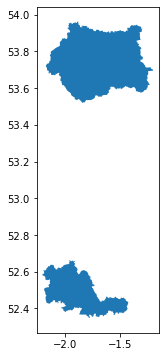

In [17]:
areas.plot(figsize=(6, 6))

## Clean out incomplete plans

In [18]:
def remove_broken_plans(plan):
    if plan.isnull().values.any():
        return None
    for col in ["ozone", "dzone"]:
        if -8 in list(plan[col]):
            return None
    return plan

In [19]:
clean_travel_diaries = (
    travel_diaries.groupby(["IndividualID", "TravDay"], group_keys=False).apply(remove_broken_plans).reset_index(drop=True)
)

In [20]:
clean_travel_diaries.head()

,TripID,SurveyYear,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,...,mode,TripPurpose_B04ID,oact,dact,tst,tet,ozone,dzone,participation,hh_weight
0,1,2002,2,1,1,1,1,2,1,2,...,4,7,23,10,675,683,530,550,1,1
1,2,2002,2,1,1,1,1,2,2,2,...,4,6,10,8,720,735,530,550,1,1
2,3,2002,2,1,1,1,1,2,3,2,...,4,7,8,10,770,780,530,550,1,1
3,4,2002,2,1,1,1,1,2,4,2,...,12,7,10,23,1110,1130,530,550,1,1
4,5,2002,3,1,1,1,1,3,1,2,...,4,7,23,10,760,770,530,550,1,1


In [21]:
print(len(travel_diaries))
print(len(clean_travel_diaries))

149
149


## Build Mappings and apply to common fields

We simplify key trip variables such as mode and activity.

In [22]:
def string_to_dict(string):
    """Used to build dicts from NTS rtf format dictionaries (cut and paste from the NTS documentation)."""
    mapping = {}
    for line in string.split("\n"):
        _, v, l = line.split("\t")
        v = v.split(" = ")[1]
        l = l.split(" = ")[1]
        mapping[float(v)] = str(l)
    return mapping

In [23]:
mode_mapping = {
    1: "walk",
    2: "bike",
    3: "car",  #'Car/van driver'
    4: "car",  #'Car/van driver'
    5: "car",  #'Motorcycle',
    6: "car",  #'Other private transport',
    7: "pt",  # Bus in London',
    8: "pt",  #'Other local bus',
    9: "pt",  #'Non-local bus',
    10: "pt",  #'London Underground',
    11: "pt",  #'Surface Rail',
    12: "car",  #'Taxi/minicab',
    13: "pt",  #'Other public transport',
    -10: "DEAD",
    -8: "NA",
}

purp_mapping = {
    1: "work",
    2: "work",  #'In course of work',
    3: "education",
    4: "shop",  #'Food shopping',
    5: "shop",  #'Non food shopping',
    6: "medical",  #'Personal business medical',
    7: "other",  #'Personal business eat/drink',
    8: "other",  #'Personal business other',
    9: "other",  #'Eat/drink with friends',
    10: "visit",  #'Visit friends',
    11: "other",  #'Other social',
    12: "other",  #'Entertain/ public activity',
    13: "other",  #'Sport: participate',
    14: "home",  #'Holiday: base',
    15: "other",  #'Day trip/just walk',
    16: "other",  #'Other non-escort',
    17: "escort",  #'Escort home',
    18: "escort",  #'Escort work',
    19: "escort",  #'Escort in course of work',
    20: "escort",  #'Escort education',
    21: "escort",  #'Escort shopping/personal business',
    22: "escort",  #'Other escort',
    23: "home",  #'Home',
    -10: "DEAD",
    -8: "NA",
}

clean_travel_diaries["mode"] = clean_travel_diaries["mode"].map(mode_mapping)
clean_travel_diaries["oact"] = clean_travel_diaries["oact"].map(purp_mapping)
clean_travel_diaries["dact"] = clean_travel_diaries["dact"].map(purp_mapping)

## Reweight and Split Days

In order to get the most from our small sample we treat individual diary days as new persons. In order to maintain the original household weighting we reduce this accordingly.

In [24]:
# reweight and split ids for unique days


def reweight(group):
    """
    Reweight based on multiple diary days, ie if an agent has two diary days, we will treat these as
    two unique agents, so we half the original weighting.
    """
    group["freq"] = group.hh_weight / group.DayID.nunique()
    return group


trips = clean_travel_diaries.groupby("IndividualID", group_keys=False).apply(reweight)
trips["pid"] = [f"{p}_{d}" for p, d in zip(trips.IndividualID, trips.TravDay)]
trips["hid"] = [f"{h}_{d}" for h, d in zip(trips.HouseholdID, trips.TravDay)]

In [25]:
trips.head()

,TripID,SurveyYear,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,...,dact,tst,tet,ozone,dzone,participation,hh_weight,freq,pid,hid
0,1,2002,2,1,1,1,1,2,1,2,...,visit,675,683,530,550,1,1,0.2,1_2,1_2
1,2,2002,2,1,1,1,1,2,2,2,...,other,720,735,530,550,1,1,0.2,1_2,1_2
2,3,2002,2,1,1,1,1,2,3,2,...,visit,770,780,530,550,1,1,0.2,1_2,1_2
3,4,2002,2,1,1,1,1,2,4,2,...,home,1110,1130,530,550,1,1,0.2,1_2,1_2
4,5,2002,3,1,1,1,1,3,1,2,...,visit,760,770,530,550,1,1,0.2,1_3,1_3


In [26]:
def expand_days(trips, target, trips_on="Diary_number", target_on="Diary_number", new_id="pid", trim=True):
    """
    Expand target df based on mapping between trips target_on and new_id.
    This is so slow. Fix
    Set index to new_id.
    """
    print("Building mapping.")
    mapping = {}
    for i, person in trips.groupby(target_on):
        mapping[i] = list(set(person[new_id]))
    n = len(mapping)

    if trim:
        print("Trimming target.")
        selection = set(trips[trips_on])
        target = target.loc[target[target_on].isin(selection)]

    expanded = pd.DataFrame()
    for p, (i, ids) in enumerate(mapping.items()):
        if not p % 10:
            print(f"Building expanded data {p}/{n}", end="\r", flush=True)
        for idx in ids:
            split = target.loc[target[target_on] == i]
            expanded = pd.concat([expanded, split.assign(**{new_id: idx})])
    expanded = expanded.set_index(new_id)
    print("Done")
    return expanded

In [27]:
hhs = expand_days(trips, hh_in, trips_on="HouseholdID", target_on="HouseholdID", new_id="hid")

Building mapping.
Trimming target.


Done


In [28]:
hhs.head()

,HouseholdID,SurveyYear,PSUID,W2,OutCom_B02ID,HHIncome2002_B02ID,AddressType_B01ID,Ten1_B02ID,Landlord_B01ID,ResLength_B01ID,...,NumCarVan,WalkBus_B01ID,Getbus_B01ID,WalkRail_B01ID,WalkRailAlt_B01ID,HRPWorkStat_B02ID,HRPSEGWorkStat_B01ID,HHoldOAClass2011_B03ID,Settlement2011EW_B03ID,Settlement2011EW_B04ID
hid,,,,,,,,,,,,,,,,,,,,,
1_3,1,2002,1,1,1,2,3,1,-10,3,...,2,1,5,1,-9,1,3,-10,1,1
1_2,1,2002,1,1,1,2,3,1,-10,3,...,2,1,5,1,-9,1,3,-10,1,1
1_1,1,2002,1,1,1,2,3,1,-10,3,...,2,1,5,1,-9,1,3,-10,1,1
1_6,1,2002,1,1,1,2,3,1,-10,3,...,2,1,5,1,-9,1,3,-10,1,1
1_5,1,2002,1,1,1,2,3,1,-10,3,...,2,1,5,1,-9,1,3,-10,1,1


In [29]:
people = expand_days(trips, persons_in, trips_on="IndividualID", target_on="IndividualID", new_id="pid")

Building mapping.
Trimming target.


Done


In [30]:
people.head()

,SurveyYear,IndividualID,HouseholdID,PSUID,VehicleID,PersNo,Age_B01ID,OfPenAge_B01ID,Sex_B01ID,EdAttn1_B01ID,...,CarAccess_B01ID,DrivDisable_B01ID,WkPlace_B01ID,ES2000_B01ID,NSSec_B03ID,SC_B01ID,Stat_B01ID,SVise_B01ID,EcoStat_B02ID,PossHom_B01ID
pid,,,,,,,,,,,,,,,,,,,,,
1_3,2002,1,1,1,1,1,13,2,2,-10,...,2,-9,1,7,2,3,1,2,2,2
1_2,2002,1,1,1,1,1,13,2,2,-10,...,2,-9,1,7,2,3,1,2,2,2
1_6,2002,1,1,1,1,1,13,2,2,-10,...,2,-9,1,7,2,3,1,2,2,2
1_5,2002,1,1,1,1,1,13,2,2,-10,...,2,-9,1,7,2,3,1,2,2,2
1_7,2002,1,1,1,1,1,13,2,2,-10,...,2,-9,1,7,2,3,1,2,2,2


## Load into PAM

We load the pandas formatted data into Pam using the `pam.read.load_travel_diary_from_to` read method. We do some very preliminary validation of plans and assurance.

In [31]:
trips.tst = trips.tst.astype(int)
trips.tet = trips.tet.astype(int)

In [32]:
population = read.load_travel_diary(
    trips=trips, persons_attributes=people, hhs_attributes=hhs, trip_freq_as_person_freq=True,
)

Using from-to activity parser using 'oact' and 'dact' columns


Adding pid->hh mapping to persons_attributes from trips.



        Unable to load household area ('hzone') - not found in trips_diary or unable to build from attributes.
        Pam will try to infer home location from activities, but this behaviour is not recommended.
        


Using freq of 'None' for all trips.


Using freq of 'None' for all households.


 Person pid:2_5 hid:1_5 plan does not start with 'home' activity: work


 Person pid:2_6 hid:1_6 plan does not start with 'home' activity: work


 Person pid:3_6 hid:1_6 plan does not start with 'home' activity: education


 Person pid:2_7 hid:1_7 plan does not start with 'home' activity: work


hello there


In [33]:
population.fix_plans()

In [34]:
# this should be replaced with a more direct method
for hh in population.households.values():
    for p in hh.people.values():
        p.validate()

In [35]:
population.size  # this also accounts for the weighting

3.285714285714285

In [36]:
population.stats

{'num_households': 18,
 'num_people': 39,
 'num_activities': 175,
 'num_legs': 136}

In [37]:
population.activity_classes

{'education', 'escort', 'home', 'medical', 'other', 'shop', 'visit', 'work'}

In [38]:
population.mode_classes

{'car', 'pt', 'walk'}

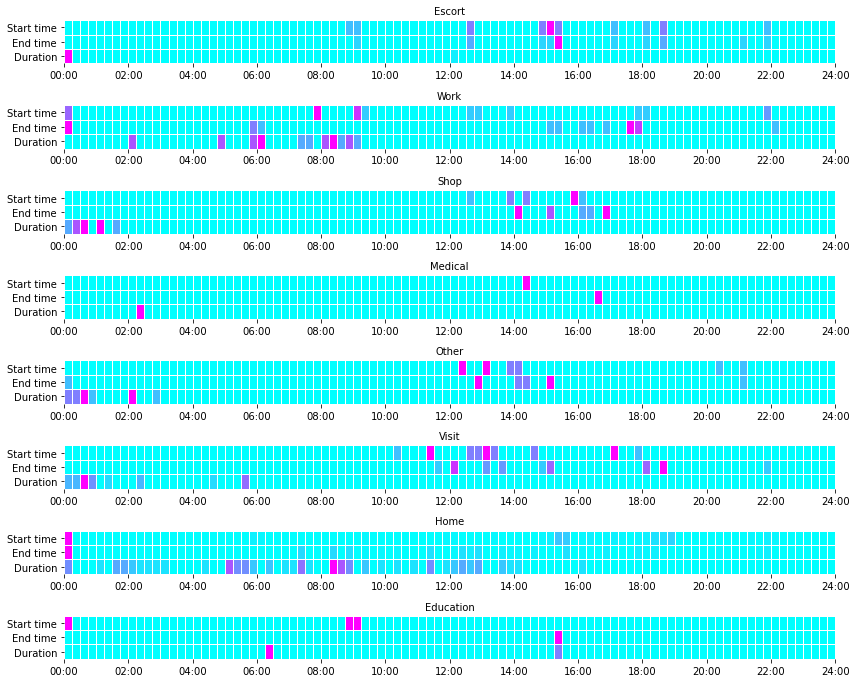

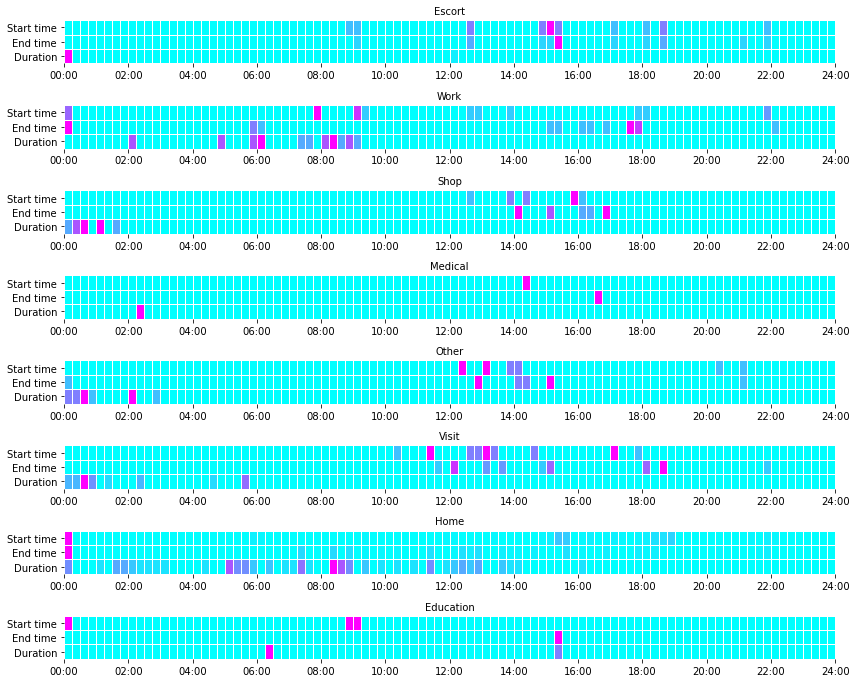

In [39]:
plot_activity_times(population)

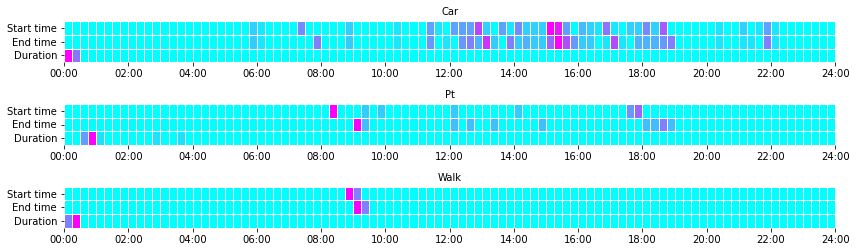

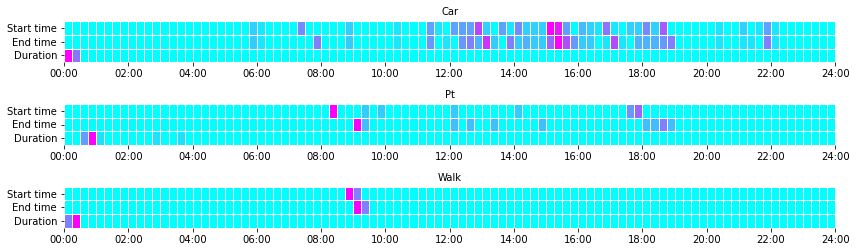

In [40]:
plot_leg_times(population)

In [41]:
# night shift @ 2016008863_6

Household: 1_1
{'HouseholdID': 1, 'SurveyYear': 2002, 'PSUID': 1, 'W2': 1, 'OutCom_B02ID': 1, 'HHIncome2002_B02ID': 2, 'AddressType_B01ID': 3, 'Ten1_B02ID': 1, 'Landlord_B01ID': -10, 'ResLength_B01ID': 3, 'HHoldCountry_B01ID': 1, 'HHoldGOR_B02ID': 7, 'HHoldNumAdults': 2, 'HHoldNumChildren': 2, 'HHoldNumPeople': 4, 'HHoldStruct_B02ID': 5, 'NumLicHolders': 2, 'HHoldEmploy_B01ID': 5, 'NumVehicles': 2, 'NumBike': 0, 'NumCar': 2, 'NumMCycle': 0, 'NumVanLorry': 0, 'NumCarVan': 2, 'WalkBus_B01ID': 1, 'Getbus_B01ID': 5, 'WalkRail_B01ID': 1, 'WalkRailAlt_B01ID': -9, 'HRPWorkStat_B02ID': 1, 'HRPSEGWorkStat_B01ID': 3, 'HHoldOAClass2011_B03ID': -10, 'Settlement2011EW_B03ID': 1, 'Settlement2011EW_B04ID': 1}
Person: 2_1
{'SurveyYear': 2002, 'IndividualID': 2, 'HouseholdID': 1, 'PSUID': 1, 'VehicleID': '2', 'PersNo': 2, 'Age_B01ID': 13, 'OfPenAge_B01ID': 2, 'Sex_B01ID': 1, 'EdAttn1_B01ID': -10, 'EdAttn2_B01ID': -10, 'EdAttn3_B01ID': -10, 'DrivLic_B02ID': 1, 'CarAccess_B01ID': 2, 'DrivDisable_B01ID': 

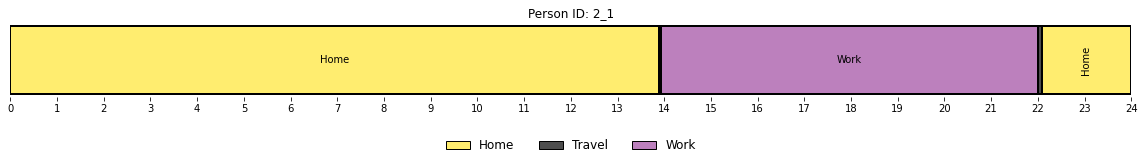

In [42]:
hh = population.random_household()
hh.print()
hh.plot()

In [43]:
population.activity_classes

{'education', 'escort', 'home', 'medical', 'other', 'shop', 'visit', 'work'}

## Sample the Population

We sample a very small population based on the given NTS household weightings.

In [44]:
from copy import deepcopy

from pam.core import Population
from pam.samplers.basic import freq_sample

population_sample = Population()

for _hid, household in population.households.items():
    av_hh_weight = household.freq  # this is currently the av of person freq in the hh
    freq = freq_sample(av_hh_weight, 10)

    for idx in range(freq):
        hh = deepcopy(household)
        hh.hid = f"{hh.hid}_{idx}"
        hh.people = {}
        for pid, person in household.people.items():
            p = deepcopy(person)
            p.pid = f"{pid}_{idx}"
            hh.add(p)
        population_sample.add(hh)

In [45]:
population_sample.size

6.72619047619048

## Facility Sampling

The facilities input is prepared using a separate project called OSM-Facility Sampler (OSMFS). This project woulbe be better names the OSM Facility *Extractor*. We use it to extract viable activity locations for each activity type for each zone. This project is not currently open source, but is described below:

OSMFS joins osm data with the geographies of an area to create a mapping between zones, acts and facility locations (points). This is output as a geojson:

{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"activity": "other"}, "geometry": {"type": "Point", "coordinates": [-4.5235751, 54.1698685]}},

todo: the current methodology does not support shared facilities, ie facilities with more than one activity (schools are places of education and work for example).

todo: the above json has to be rejoined with the geography to create a spatial sampler. This is a duplicated operation which could be included in the Bench output, eg:

zone_id: activity: (id, point)

In [46]:
def load_facilities(path, from_crs="EPSG:4326", to_crs="EPSG:27700"):
    facilities = gp.read_file(path)
    facilities.crs = from_crs
    facilities = facilities.to_crs(to_crs)
    return facilities


def load_zones(zones_path, from_crs="EPSG:27700", to_crs="EPSG:27700"):
    zones = gp.read_file(zones_path)
    zones = zones.set_index("id")
    if from_crs != to_crs:
        zones.crs = from_crs
        zones = zones.to_crs(to_crs)
    return zones

## Random Sampler

Failing a facility sampler - we can use random sampling instead.

In [47]:
zones = load_zones(area_path, from_crs="EPSG:4326")
sampler = RandomPointSampler(geoms=zones)

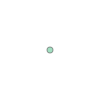

In [48]:
sampler.sample(530, None)

In [49]:
population_sample.sample_locs(sampler)

Person: 5_2_1
{'SurveyYear': 2002, 'IndividualID': 5, 'HouseholdID': 2, 'PSUID': 1, 'VehicleID': ' ', 'PersNo': 1, 'Age_B01ID': 18, 'OfPenAge_B01ID': 1, 'Sex_B01ID': 2, 'EdAttn1_B01ID': -10, 'EdAttn2_B01ID': -10, 'EdAttn3_B01ID': -10, 'DrivLic_B02ID': 3, 'CarAccess_B01ID': 6, 'DrivDisable_B01ID': 2, 'WkPlace_B01ID': -9, 'ES2000_B01ID': 6, 'NSSec_B03ID': 1, 'SC_B01ID': 3, 'Stat_B01ID': 1, 'SVise_B01ID': 1, 'EcoStat_B02ID': 4, 'PossHom_B01ID': -9}
0:	Activity(act:home, location:POINT (419883.4863206614 274232.598586247), time:00:00:00 --> 09:45:00, duration:9:45:00)
1:	Leg(mode:pt, area:POINT (419883.4863206614 274232.598586247) --> POINT (408021.8785798442 447678.35816789983), time:09:45:00 --> 13:15:00, duration:3:30:00)
2:	Activity(act:home, location:POINT (408021.8785798442 447678.35816789983), time:13:15:00 --> 00:00:00, duration:10:45:00)


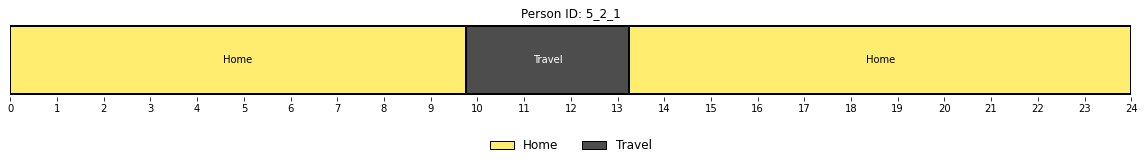

In [50]:
person = population_sample.random_person()
person.plot()
person.print()

## Write to Disk

1. write MATSim formats to disk (plans and attributes)
2. write csv and geojson summaries to disk
3. write MATSim formatted facilities to disk

In [51]:
comment = "NTS london prelim 24nov2020 epsg27700"

write.write_matsim(population_sample, plans_path=os.path.join(out_dir, "plans.xml"), comment=comment)
population_sample.to_csv(out_dir, crs="EPSG:27700", to_crs="EPSG:4326")